# Testing AG Coordinate 

This notebook evaluates the performance of the AG coordinate using a single density slice snapshot from the ANU-tub configuration. The AG coordinate is calculated using Angus' `pyale` package - these calculations are done within the notebook - see also `AG_VertRegrid.py` and `Evaluate_AG_Coord.ipynb` for a more thorough evaluation.

The `pyale` code is fortran-based, and pretty slow, so best to enable OpenMP to use multi-threading. Note that the cell below needs to be in the environment *before* OpenMP is initialised, which happens when you import the `pyale` module. Ideal is to match the number of threads with the number of cores available.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(28)

Import precompiled `pyale` code - note that you will need to match the python version here, or recompile to a newer version of python if that fails.

In [2]:
import toml
import sys
sys.path = ["/g/data/x77/ahg157/python-ale/build/lib.linux-x86_64-cpython-310"] + sys.path
import pyale

Import other standard plotting stuff.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm

## Load grid information into dataset

This just uses a random restart file copied locally.

In [4]:
restart_filename = '/g/data/x77/amh157/anu-tub/diagnostics/INPUTS/MOM.res.nc'

In [5]:
ds2 = xr.open_dataset(restart_filename)

Text(0.5, 1.0, 'Temperature')

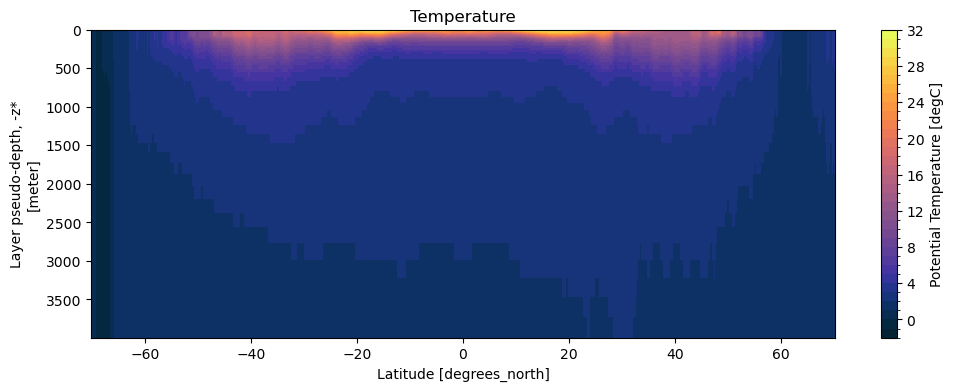

In [6]:
vlev = np.linspace(-2,32,35)
plt.figure(figsize=(12,4))
ds2.Temp.isel(Time=0).isel(lonh=39).plot(levels=vlev,cmap=cm.cm.thermal)
plt.gca().invert_yaxis()
plt.title('Temperature')

## Load Standard Adaptive Params
This function reads in the parameters from the default `.toml` file, and sets up the function. Note that we have optimised default parameters and specify updated parameters manually -- see `Evaluate_AG_Coord.ipynb` for details. 

In [7]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
params["ADAPT_RESTORING_TIMESCALE"] = 50*86400        # default was 10 days
params["ADAPT_SMOOTH_MIN"] = 0.2                      # default is 0.1
cs = pyale.mom_init_cs(params); 

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [8]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [9]:
%%time
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=20, dt=3600)

CPU times: user 4min 12s, sys: 17.5 s, total: 4min 30s
Wall time: 24 s


In [10]:
def tpplot(field,h,vlev=50,cmap=cm.cm.thermal):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([0,500])
    plt.gca().invert_yaxis()
    plt.subplot(212)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    plt.subplots_adjust(hspace=0)
    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)

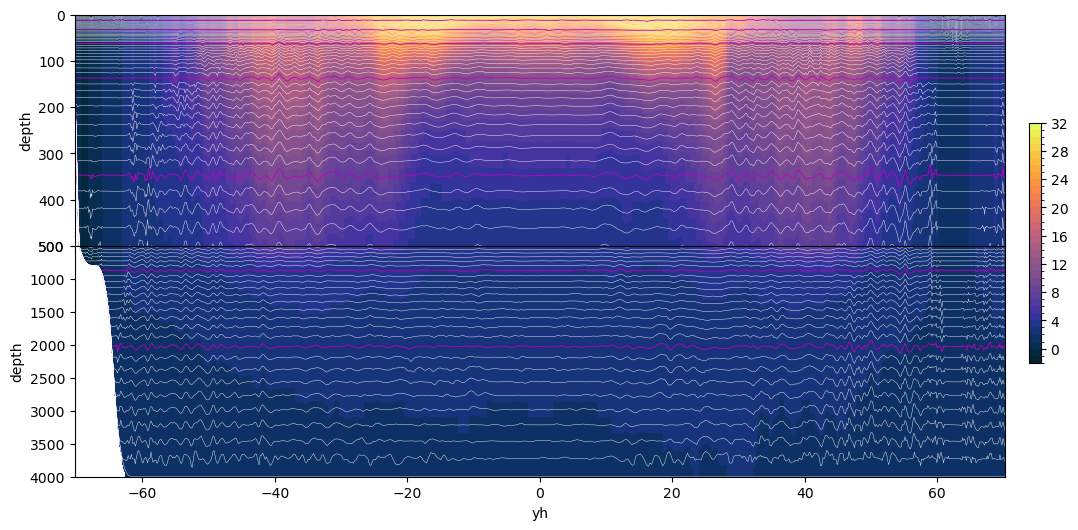

In [11]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

mean T gradient is 0.6416379587579812


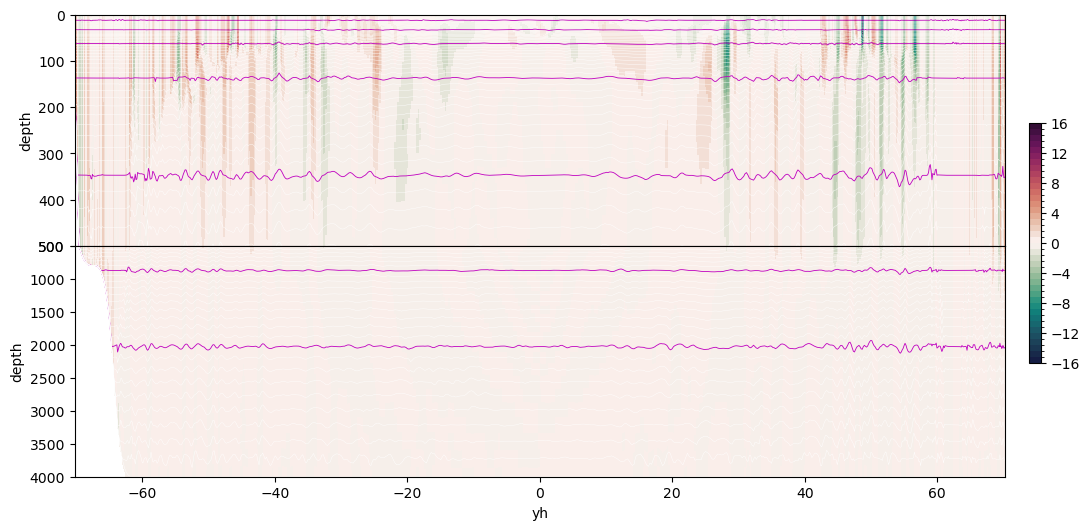

In [12]:
delT = new_temp.differentiate("yh")
tpplot(delT,h_depth,cmap=cm.cm.curl)
print("mean T gradient is", np.fabs(delT).mean().values) # should really weight this by cell volume

Key issue here is that, even within the isopycnal-like layers, there are residual meridional temperature gradients that don't dissipate even with more iterations. The question is which terms in the equation cause this behaviour.

In [13]:
(h, temp, salt, diags) = pyale.accelerate_ale(cs, adapt_cs, iter=1, dt=3600, diags=["adapt_slope_u","adapt_slope_v","adapt_denom_u", "adapt_denom_v"])

In [20]:
diags['adapt_slope_u'].shape

(168, 807, 76)

In [19]:
np.count_nonzero(diags['adapt_slope_u'])

0

In [16]:
h_depth = np.cumsum(h[39,:,:],1)
diag = xr.DataArray(data=np.transpose(diags['adapt_slope_u'][39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(diag,h_depth,vlev=vlev,cmap=cm.cm.thermal)

ValueError: conflicting sizes for dimension 'yh': length 807 on the data but length 800 on coordinate 'yh'

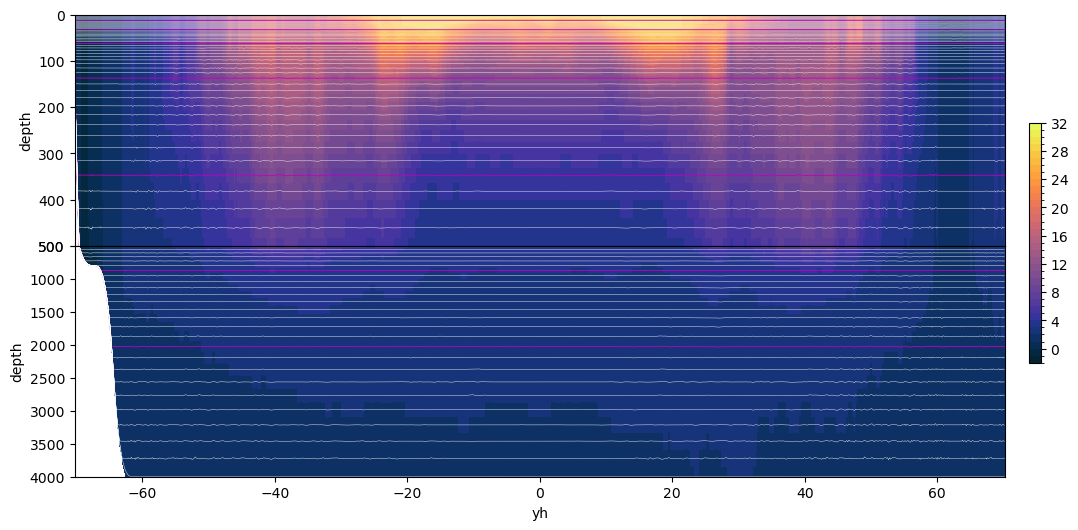

In [13]:
state = pyale.accelerate_ale(cs, adapt_cs, iter=1, dt=3600)
h_depth = np.cumsum(state[0][39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(state[1][39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

In [ ]:
state_old = state
state = pyale.resume_ale(cs, adapt_cs, state_old, 1, dt=3600)
h_depth = np.cumsum(state[0][39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(state[1][39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

----------

### Below here not very relevant.

In [ ]:
%%time
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=100, dt=3600)

In [ ]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

In [ ]:
delT = new_temp.differentiate("yh")
tpplot(delT,h_depth,cmap=cm.cm.curl)
print("mean T gradient is", np.fabs(delT).mean().values) # should really weight this by cell volume

## Not sure what is going on here.

There doesn't seem to be any isopycnal adjustment going on here, but instead just a couple of spikes in layer thickness neear the continental shelf.

Also, the deepest layers is thickening, which is confusing.

I suspect there is a bug somewhere -- because this is different to the model output. WIll play with parameters to seach for it.

In [29]:
#params["ADAPT_TIMESCALE"] = 300.0             # was 3600
#params["REGRID_TIME_SCALE"] = 86400.0           # was 86400
#params["ADAPT_SMOOTH_MIN"] = 0.0             # was 0.1
#params["ADAPT_ADJUSTMENT_SCALE"] = 0.0        # was 0.1
params["ADAPT_TWIN_GRADIENT"] = True
params["ADAPT_PHYSICAL_SLOPE"] = True
params["ADAPT_SLOPE_CUTOFF"] = 0.0001
cs = pyale.mom_init_cs(params)

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  F
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  F
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                              NIPROC:            1
 MOM_domains                              NJPROC:            1
 MOM_domains                              LAYOUT:     

In [30]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [37]:
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=10, dt=3600)

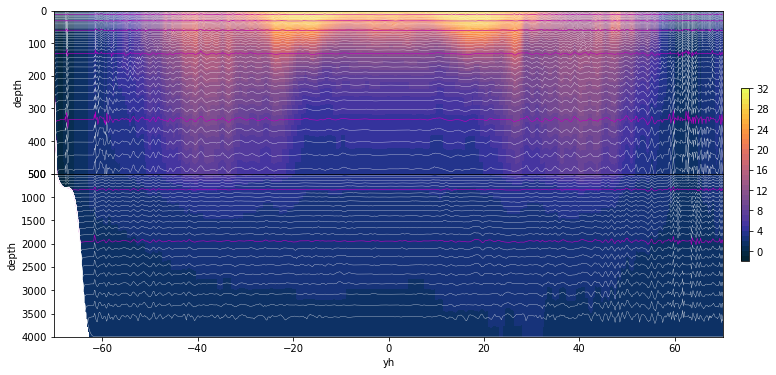

In [38]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
            #attrs= u.attrs)
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)

ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)

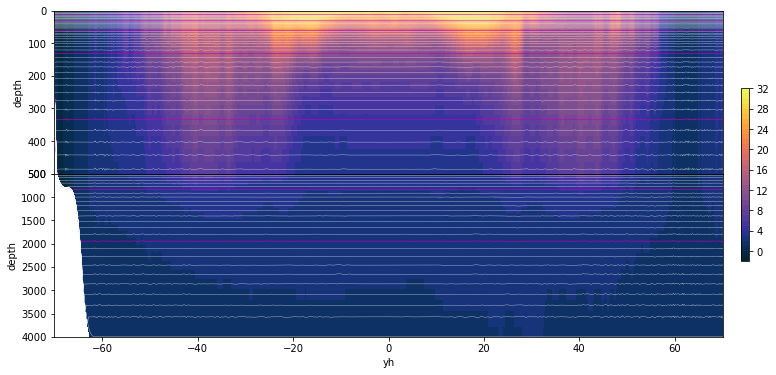

In [34]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
            #attrs= u.attrs)
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)

ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)

## Summary 

Parameter changes:
* `ADAPT_SMOOTH_MIN` seems to be creating the spikes at topography. At least, they disappear when I set that to zero.
* I don't understand why all these parameters are set to "F", even if I specifically set them to "T":
```    
 init_MOM_state ADAPT_MEAN_H:  F
 init_MOM_state ADAPT_TWIN_GRADIENT:  F
 init_MOM_state ADAPT_PHYSICAL_SLOPE:  F
 init_MOM_state ADAPT_RESTORE_MEAN:  F
 ```
* None of the other parameters seem to do anything.


In [17]:
!echo $OMP_NUM_THREADS

28


In [16]:
os.environ["OMP_NUM_THREADS"] = str(28)

In [15]:
import os